<a href="https://colab.research.google.com/github/UrbanGISer/XGeoML/blob/main/XGeoML_2_GeoShapley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explainable Geospatial Machine Learning Model-2 GeoShapley

Lingbo Liu

Center for Geographical Analysis

Harvard University

Lingboliu@fas.harvard.edu


**Part 2: Comparsion with GeoShapley**

## 0 Install packages

In [ ]:
#Note: After installing hyperopt-sklearn, restart your session to use the latest Numpy Package.
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-c9ow6b7p
  Running command git clone --filter=blob:none --quiet https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-c9ow6b7p
  Resolved https://github.com/hyperopt/hyperopt-sklearn to commit 4bc286479677a0bfd2178dac4546ea268b3f3b77
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 30.3 MB/s eta 0:00:00
  Created wheel for hpsklearn: filename=hpsklearn-1.0.3-py3-none-any.whl size=135342 sha256=e6930eeb1a91d64871d89e35f6d7cc504ba21baed9b151f017bc9ba87e53d4f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-weg6wesp/wheels/01/e8/01/ad06c89501e4845c988d4e846f45f3485d9b60be0b9ebea43b
Successfully built hpsklearn
  Attempting uninstall: numpy
    Found existing installation: numpy 1

In [ ]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=c66cd606690c3c03239d2a03d252765087dd5b440c6c6031f49f595b3eb5fc5b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install mgwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 23.2 MB/s eta 0:00:00


In [ ]:
!pip install geoshapley

In [ ]:
import hpsklearn.components
import types

# 列出hpsklearn.components模块中所有的回归模型
regression_models = [name for name, obj in hpsklearn.components.__dict__.items()
                     if isinstance(obj, types.FunctionType) and name.endswith('_regressor')]

print("Available regression models in hpsklearn.components:")
for model in regression_models:
    print(model)

Available regression models in hpsklearn.components:
random_forest_regressor
extra_trees_regressor
bagging_regressor
ada_boost_regressor
gradient_boosting_regressor
hist_gradient_boosting_regressor
poisson_regressor
gamma_regressor
tweedie_regressor
huber_regressor
sgd_regressor
passive_aggressive_regressor
theil_sen_regressor
dummy_regressor
gaussian_process_regressor
mlp_regressor
decision_tree_regressor
extra_tree_regressor
transformed_target_regressor
k_neighbors_regressor
radius_neighbors_regressor
any_regressor
any_sparse_regressor


# 1 Create Synthetic Data

In [ ]:
import numpy as np
import pandas as pd
import math
# Grid setup (assuming these values are already defined)
grid_size = 30
u = np.repeat(np.arange(1, grid_size + 1), grid_size)
v = np.tile(np.arange(1, grid_size + 1), grid_size)

n=grid_size **2
np.random.seed(1234567)
x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.normal(loc=0, scale=1, size=n)
x3 = np.random.normal(loc=0, scale=1, size=n)
x4 = np.random.normal(loc=0, scale=1, size=n)
x5 = np.random.normal(loc=0, scale=1, size=n)
x6 = np.random.normal(loc=0, scale=1, size=n)
epsilon = np.random.normal(loc=0, scale=0.5, size=n)


# 1-Degree for linear gradient
angle_degrees = 45
angle_radians = np.radians(angle_degrees)

# 1-Linear discrete band
n_bands = 10

# Calculate increase X Y
dx = np.cos(angle_radians)
dy = np.sin(angle_radians)

# Projection
X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
projection = dx * X + dy * Y

# Normal [0, 1]
alpha1 = (projection - np.min(projection)) / (np.max(projection) - np.min(projection))
alpha2 = np.floor(alpha1 * n_bands) / n_bands

beta_linear= alpha1.flatten()
beta_lineardiscrete = alpha2.flatten()

# 2-Cosine
scale= 2
GS=grid_size/scale

beta_cos = 1 + 2 * (np.cos(math.pi * u / grid_size) * np.cos(math.pi * v / grid_size))
# beta_cos /= (beta_cos - np.min(beta_cos)) / (np.max(beta_cos) - np.min(beta_cos))
beta_cos_flat1 = beta_cos.flatten()


beta_cos = 1 + 2 * (np.cos(math.pi * u / GS) * np.cos(math.pi * v / GS))
# beta_cos /= (beta_cos - np.min(beta_cos)) / (np.max(beta_cos) - np.min(beta_cos))
beta_cos_flat2 = beta_cos.flatten()


# 3. Circular Gradient
radius_k=10
position_x=2
position_y=2

center_x, center_y = grid_size / position_x, grid_size / position_y  # center of the circle
radius = grid_size *radius_k  # radius of the circle
Y, X = np.ogrid[:grid_size, :grid_size]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
alpha3 = np.clip(1 - dist_from_center / radius, 0, 1)


# alpha3 /= (alpha3 - np.min(alpha3)) / (np.max(alpha3) - np.min(alpha3))
beta_circular_flat = alpha3.flatten()

# 4. Kernel Density Gradient (alpha4) with manual kernels
# Random Generate
# n_points = 3
# kernel_s=3
# kernel_e=10
# kernel_radii = np.random.uniform(kernel_s, kernel_e, n_points)  # different kernel radii for each point
# points = np.vstack([np.random.uniform(0, grid_size, n_points), np.random.uniform(0, grid_size, n_points)])
kernel_radii = np.array([7, 3, 5 ])
points = np.array([[ 8,  10,  25],
       [11, 28, 4]])

# Initialize alpha4 grid
alpha4 = np.zeros((grid_size, grid_size))

# Apply a Gaussian kernel to each point and sum the results
for point, radius in zip(points.T, kernel_radii):
    Y, X = np.ogrid[:grid_size, :grid_size]
    dist_from_point = np.sqrt((X - point[0])**2 + (Y - point[1])**2)
    gaussian = np.exp(-(dist_from_point**2 / (2. * radius**2)))
    alpha4 += gaussian

# alpha4 /= (alpha4 - np.min(alpha4)) / (np.max(alpha4) - np.min(alpha4))
alpha4_flat = alpha4.flatten()


df = pd.DataFrame({
    'u': u,
    'v': v,
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'x5': x5,
    'x6': x6,
    'e': epsilon,
    'b_linear': beta_linear,
    'b_lineardiscrete': beta_lineardiscrete,
    'b_cos_basic': beta_cos_flat1,
    'b_cos_ad': beta_cos_flat2,
    'b_circular': beta_circular_flat,
    'b_poly': alpha4_flat,
})




In [ ]:
# 计算每列的最小值和最大值
min_values = df.min()
max_values = df.max()

# 定义缩放的目标范围
min_range = 0
max_range = 5

# 对每列进行 min-max 缩放
for column in ['b_linear','b_lineardiscrete','b_cos_basic','b_cos_ad','b_circular','b_poly']:
    df[column] = min_range + (df[column] - min_values[column]) * (max_range - min_range) / (max_values[column] - min_values[column])


In [ ]:
df['y'] = df['b_linear'] * df['x1'] + df['x2'] * df['b_circular'] + df['x3']**2 * df['b_cos_basic'] + df['x4']**3 * df['b_poly']+df['e']

In [ ]:
df.head(5)

,u,v,x1,x2,x3,x4,x5,x6,e,b_linear,b_lineardiscrete,b_cos_basic,b_cos_ad,b_circular,b_poly,y
0,1,1,-0.514625,0.688297,0.992160,0.620480,1.068074,1.142192,-0.054045,0.000000,0.0,4.972609,4.891932,0.000000,0.719144,5.012690
1,1,2,-0.449554,-0.391767,-0.556702,0.386716,-0.224860,0.788291,-0.623987,0.086207,0.0,4.931786,4.733956,0.163794,0.838430,0.850026
2,1,3,1.734621,-0.240266,0.449129,1.595730,0.474081,-0.279895,0.035431,0.172414,0.0,4.864244,4.478345,0.321444,0.957690,5.129849
3,1,4,0.643380,-0.070372,0.063307,0.408018,-0.153461,-1.031303,-0.281256,0.258621,0.0,4.770724,4.136271,0.472307,1.071801,-0.056179
4,1,5,0.026139,0.442559,1.255714,-1.568991,-0.745217,-0.004208,-0.458297,0.344828,0.0,4.652251,3.722685,0.615685,1.175354,2.619219


In [ ]:
df.to_csv("/content/df.csv")

isualization

In [ ]:
truebeta= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

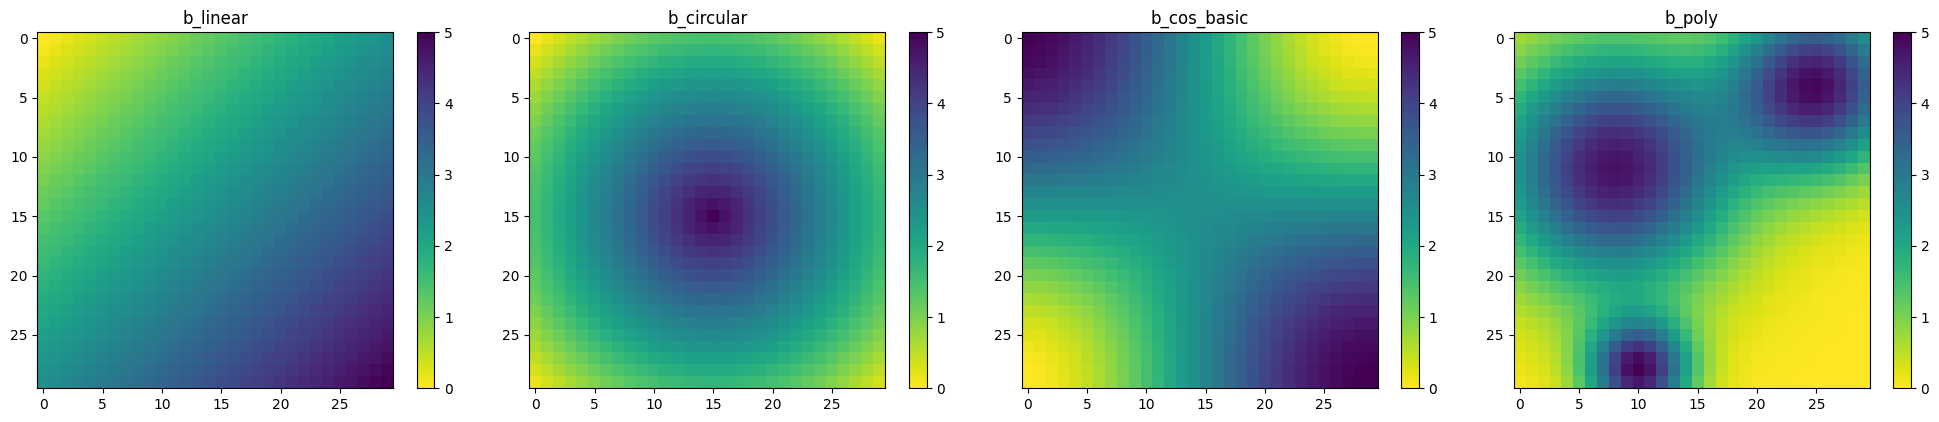

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    plt.colorbar(im, ax=ax,
                #  label='Value',
                 )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 数据和标题
data_list = [df.pivot(index='u', columns='v', values=i) for i in truebeta]
titles =truebeta

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()


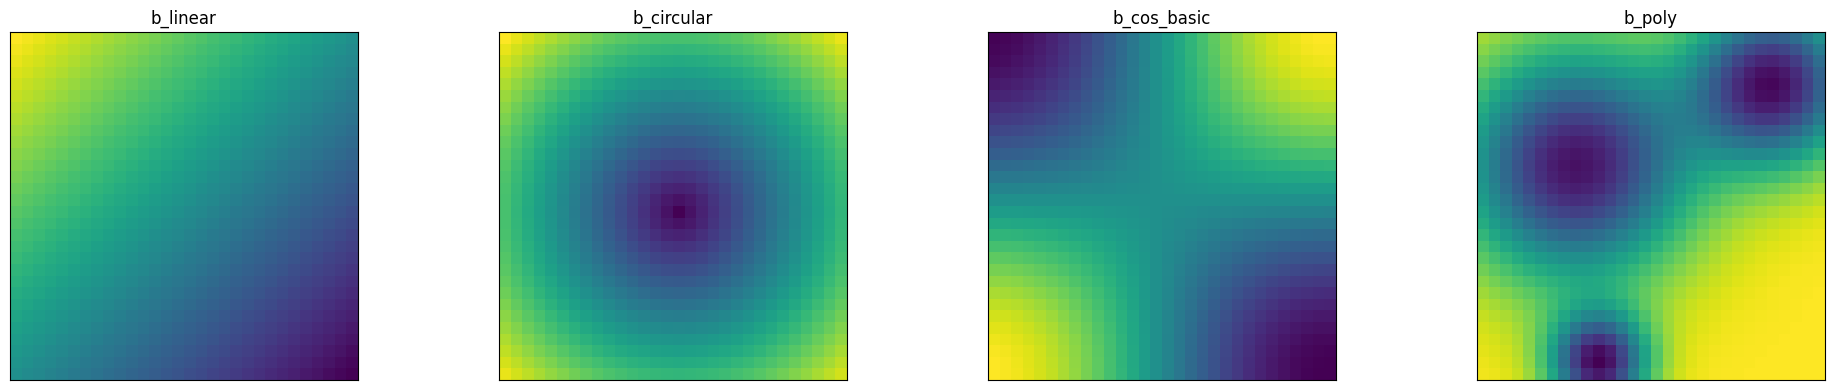

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest', vmin=0, vmax=5)
    ax.set_title(title)
    # 移除x轴和y轴的刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
# 数据和标题
data_list = [df.pivot(index='u', columns='v', values=i) for i in truebeta]
titles = truebeta
axes_flat = axes.flatten()

for ax, data, title in zip(axes_flat, data_list, titles):
        plot_heatmap(ax, data, title)

# 调整子图布局
plt.tight_layout()
plt.show()


# 2 GeoShapley

In [ ]:
import numpy as np
import pandas as pd
import warnings
import shap
import matplotlib.pyplot as plt
from geoshapley import GeoShapleyExplainer

In [ ]:
from scipy.stats import linregress

In [ ]:
import mgwr

## 2-1 GeoShapley with MLP

### 2-1-1 Run Hyperopt MLP

In [ ]:
from hpsklearn import HyperoptEstimator, xgboost_regression, mlp_regressor
from hyperopt import tpe
from sklearn.model_selection import train_test_split

In [ ]:
X_coords = df[['x1','x2','x3','x4','u','v']]
y = df.y.values
true = df[['b_linear','b_circular', 'b_cos_basic',  'b_poly']].values
X_train, X_test, y_train, y_test = train_test_split(X_coords, y,random_state=1)

In [ ]:
def train_any_model(any_regressor,max_evals=10):
    estim = HyperoptEstimator(regressor=any_regressor("myModel"),preprocessing=[],
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=60,seed=1)
    estim.fit(X_train, y_train)
    return estim

In [ ]:
%%time
for i in range(0,200):
    try:
        tmodel = train_any_model(mlp_regressor)
        break
    except:
        pass

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

Stochastic Optimizer: Maximum iterations (263) reached and the optimization hasn't converged yet.



 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

Stochastic Optimizer: Maximum iterations (218) reached and the optimization hasn't converged yet.



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

Stochastic Optimizer: Maximum iterations (265) reached and the optimization hasn't converged yet.



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

Stochastic Optimizer: Maximum iterations (319) reached and the optimization hasn't converged yet.



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

Stochastic Optimizer: Maximum iterations (166) reached and the optimization hasn't converged yet.



 90%|█████████ | 9/10 [00:00<?, ?trial/s, best loss=?]

Stochastic Optimizer: Maximum iterations (224) reached and the optimization hasn't converged yet.



100%|██████████| 10/10 [00:02<00:00,  2.09s/trial, best loss: 0.23684156818693647]
CPU times: user 1.66 s, sys: 1.25 s, total: 2.91 s
Wall time: 11.8 s


Stochastic Optimizer: Maximum iterations (224) reached and the optimization hasn't converged yet.


In [ ]:
ypred_train=tmodel.predict(X_train)
ypred_test=tmodel.predict(X_test)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score

def evaluate_regression_metrics(y_true, y_pred):
    # 计算 MSE（均方误差）
    mse = mean_squared_error(y_true, y_pred)
    # 计算 RMSE（均方根误差）
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    # 计算 MAE（平均绝对误差）
    mae = mean_absolute_error(y_true, y_pred)
    # 计算 MAPE（平均绝对百分比误差）
    # mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # 计算 Median Absolute Error（中位数绝对误差）
    median_ae = median_absolute_error(y_true, y_pred)
    # 计算 R^2（决定系数）
    r2 = r2_score(y_true, y_pred)
    # 封装结果成一个数组
    metrics_array = np.array([mse, rmse, mae, median_ae, r2])

    return metrics_array

In [ ]:
evaluate_regression_metrics( y_train, ypred_train)

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


array([2.90045346, 1.70307177, 1.32244483, 1.06523911, 0.96896181])

In [ ]:
evaluate_regression_metrics( y_test, ypred_test)

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


array([111.36670242,  10.55304233,   3.72170531,   2.0603275 ,
         0.5127043 ])

In [ ]:
ypred_all=tmodel.predict(X_coords)

In [ ]:
evaluate_regression_metrics( y, ypred_all)

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


array([30.0170157 ,  5.47877867,  1.92225995,  1.2095811 ,  0.76417637])

### 2-1-2 Run GeoShapley

In [ ]:
background_X = X_coords.values

In [ ]:
m_explainer = GeoShapleyExplainer(tmodel.predict, background_X)

m_rslt = m_explainer.explain(X_coords,n_jobs=-1)

  0%|          | 0/900 [00:00<?, ?it/s]

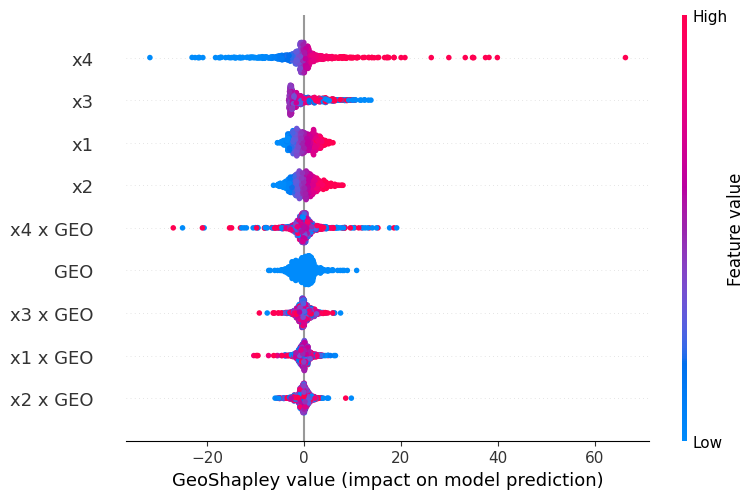

In [ ]:
m_rslt.summary_plot(dpi=100)

In [ ]:
m_rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
x4,-31.749625,-1.794861,-0.130401,1.047559,66.269813,-0.020914,6.550198,3.417356
x3,-3.147468,-2.477764,-1.216019,1.526818,13.812065,-0.001718,3.202217,2.503563
x1,-5.467156,-1.775134,-0.066142,1.824850,5.986968,0.029840,2.274608,1.921911
x2,-6.282845,-1.602078,-0.043033,1.552859,8.053435,0.052158,2.379836,1.886545
x4 x GEO,-26.938286,-0.908474,-0.028461,0.955514,19.117801,0.041829,3.460038,1.865235
GEO,-7.273337,-1.190940,0.189498,1.255260,10.864618,0.059366,1.916742,1.470331
x3 x GEO,-9.196837,-0.787545,-0.094043,0.752078,7.544174,0.003436,1.533589,1.078041
x1 x GEO,-10.337929,-0.676803,-0.051413,0.652719,6.500232,-0.059681,1.461564,0.943032
x2 x GEO,-5.947518,-0.676540,-0.060000,0.520234,9.770812,-0.104315,1.312859,0.884376


### 2-1-3 Extract Raw Shapley

In [ ]:
xvar=['x1','x2','x3','x4']
nvar = len(xvar)
L = list(range(nvar))

In [ ]:
# m_rslt.summary_plot(dpi=150)
m_raw = m_rslt.get_svc(col = L,coef_type='raw',include_primary=True)

# print(m_svc.shape)
final0=np.hstack([m_rslt.base_value + m_rslt.geo.reshape(-1,1), m_raw ])

colname= [f"{col}_shap" for col in xvar]

colname=['beta_shap']+colname
final_df0 = pd.DataFrame(final0, columns=colname)
merged_df = pd.concat([df.reset_index(drop=True), final_df0.reset_index(drop=True)], axis=1)

In [ ]:
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

In [ ]:
columnsvar=['x1_shap','x2_shap', 'x3_shap',  'x4_shap']

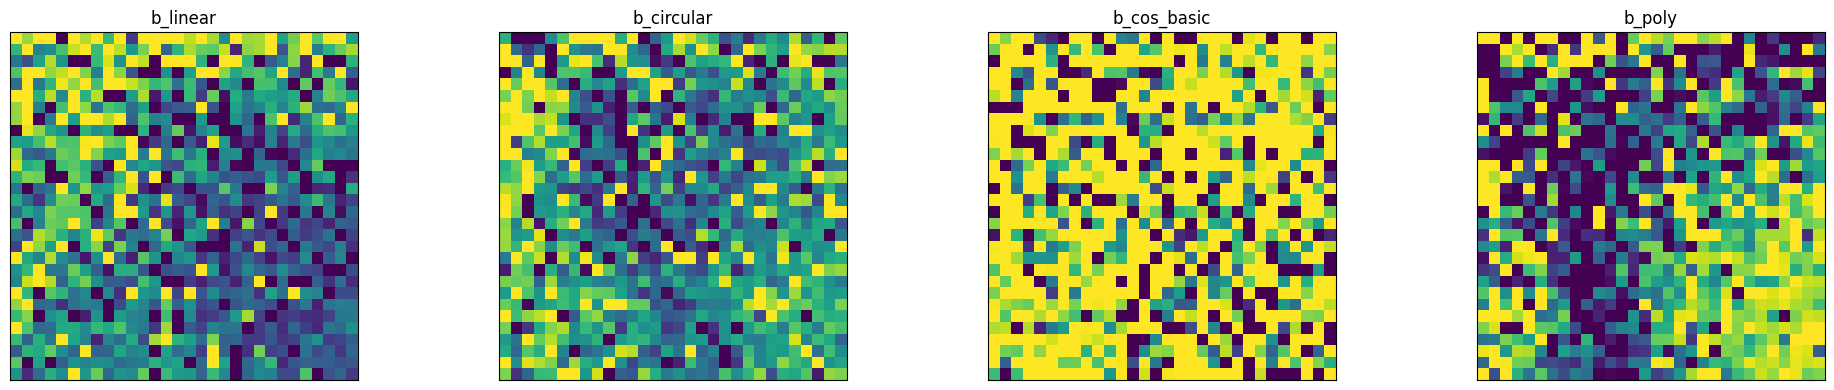

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    # plt.colorbar(im, ax=ax,
    #             #  label='Value',
    #              )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 数据和标题
data_list = [merged_df.pivot(index='u', columns='v', values=i) for i in columnsvar]
titles =targetname

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()

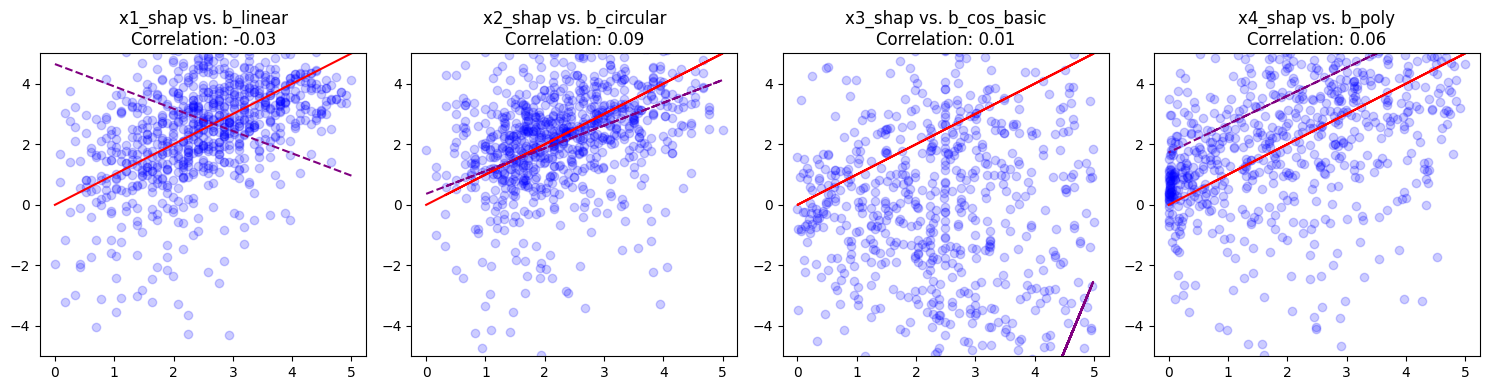

In [ ]:
# 设置图形大小
fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 2行4列

# 假设 feature_importances_df 共有8列，且 targetname 有4个元素
for idx, ax in enumerate(axes.flatten()):
    # 修正：为了在第二行使用不同的列，我们直接使用 idx 来引用列
    feature_column = columnsvar[idx]
    b_column = targetname[idx % 4]  # 使用整除来确保每行对应相同的b_column

    # 获取数据
    y = merged_df[feature_column]
    x = merged_df[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')

    # 绘制拟合直线
    ax.plot(x, x , color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    ax.plot(x, slope * x + intercept, color='purple',ls='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)
    ax.set_ylim(-5, 5)
# 调整布局
plt.tight_layout()
plt.show()

### 2-1-4 Extract GWR smoothed Shapley

In [ ]:
xvar=['x1','x2','x3','x4']
nvar = len(xvar)
L = list(range(nvar))

In [ ]:
# m_rslt.summary_plot(dpi=150)
m_gwr = m_rslt.get_svc(col = L,coef_type='gwr',include_primary=True)

# print(m_svc.shape)
final2=np.hstack([m_rslt.base_value + m_rslt.geo.reshape(-1,1), m_gwr])

colname= [f"{col}_shap" for col in xvar]

colname=['beta_shap']+colname
final_df2= pd.DataFrame(final2, columns=colname)
merged_df12= pd.concat([df.reset_index(drop=True), final_df2.reset_index(drop=True)], axis=1)

In [ ]:
from scipy.stats import linregress

In [ ]:
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

In [ ]:
columnsvar=['x1_shap','x2_shap', 'x3_shap',  'x4_shap']

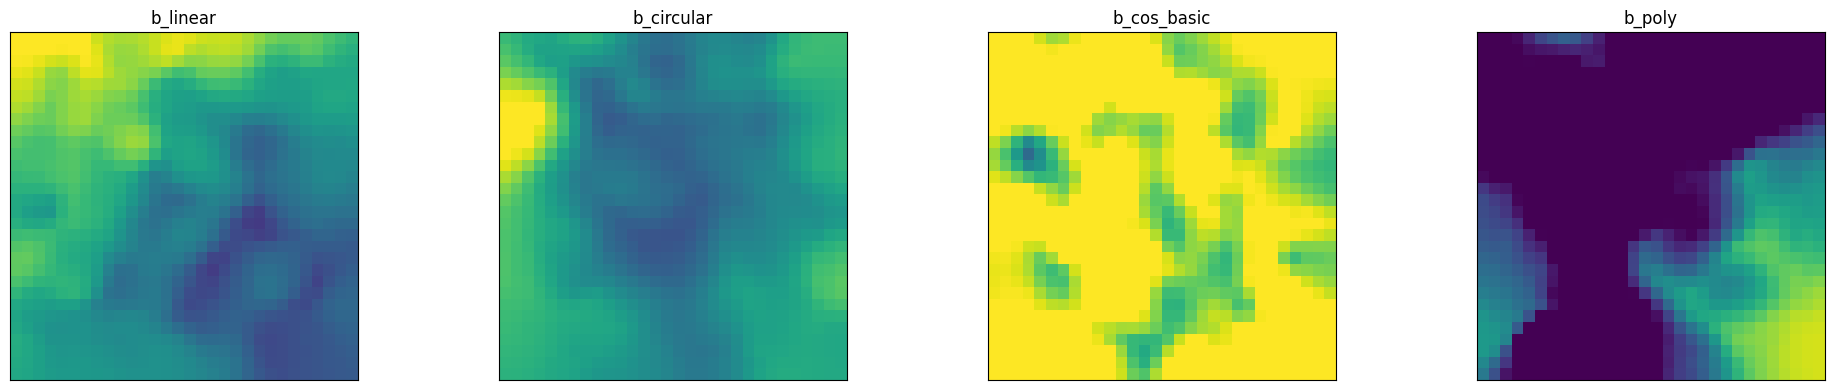

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    # plt.colorbar(im, ax=ax,
    #             #  label='Value',
    #              )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 数据和标题
data_list = [merged_df12.pivot(index='u', columns='v', values=i) for i in columnsvar]
titles =targetname

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()

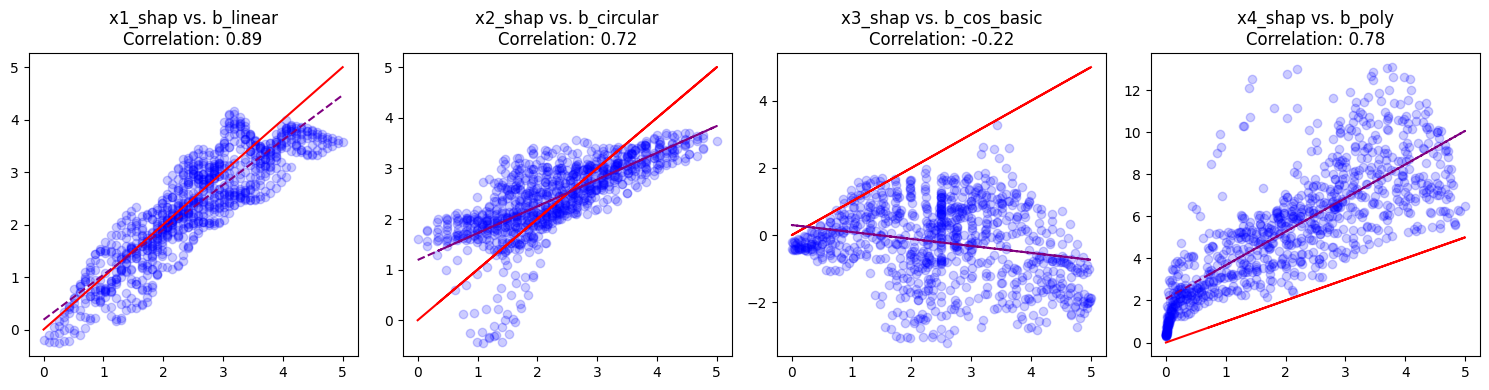

In [ ]:
# 设置图形大小
fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 2行4列

# 假设 feature_importances_df 共有8列，且 targetname 有4个元素
for idx, ax in enumerate(axes.flatten()):
    # 修正：为了在第二行使用不同的列，我们直接使用 idx 来引用列
    feature_column = columnsvar[idx]
    b_column = targetname[idx % 4]  # 使用整除来确保每行对应相同的b_column

    # 获取数据
    y = merged_df12[feature_column]
    x = merged_df12[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')

    # 绘制拟合直线
    ax.plot(x, x , color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    ax.plot(x, slope * x + intercept, color='purple',ls='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)
    # ax.set_ylim(0, 10)
# 调整布局
plt.tight_layout()
plt.show()

### 2-1-5 Partial Dependence Plot

In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.0 MB/s eta 0:00:00


100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


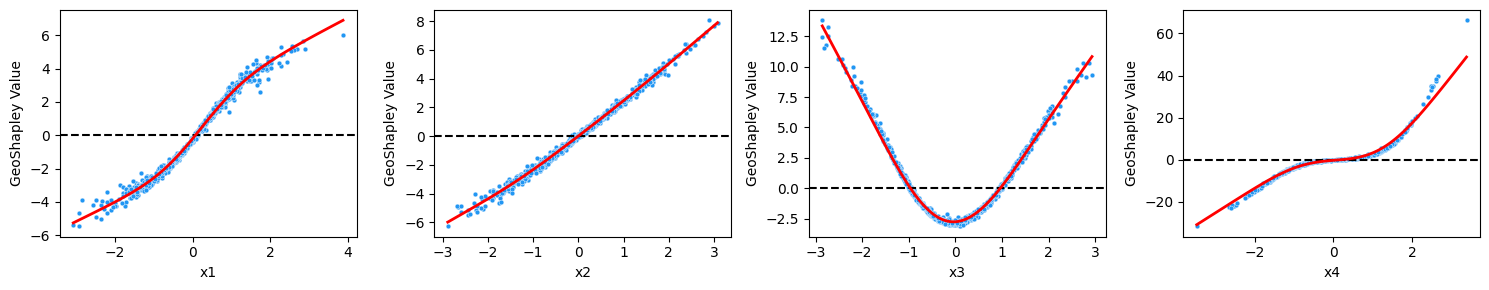

In [ ]:
m_rslt.partial_dependence_plots(figsize=(15,3),max_cols=4,gam_curve=True)

## 2-1 GeoShapley with GBR

### 2-1-1 Run Hyperopt GBR

In [ ]:
from hpsklearn import HyperoptEstimator, xgboost_regression, mlp_regressor,gradient_boosting_regressor
from hyperopt import tpe
from sklearn.model_selection import train_test_split

In [ ]:
X_coords = df[['x1','x2','x3','x4','u','v']]
y = df.y.values
true = df[['b_linear','b_circular', 'b_cos_basic',  'b_poly']].values
X_train, X_test, y_train, y_test = train_test_split(X_coords, y,random_state=1)

In [ ]:
def train_any_model(any_regressor,max_evals=20):
    estim = HyperoptEstimator(regressor=any_regressor("myModel"),preprocessing=[],
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=60,seed=1)
    estim.fit(X_train, y_train)
    return estim

In [ ]:
%%time
for i in range(0,200):
    try:
        tmodel = train_any_model(gradient_boosting_regressor)
        break
    except:
        pass

100%|██████████| 20/20 [00:06<00:00,  6.76s/trial, best loss: 0.2527762752777447]
CPU times: user 2.07 s, sys: 414 ms, total: 2.49 s
Wall time: 26.6 s


In [ ]:
ypred_train=tmodel.predict(X_train)
ypred_test=tmodel.predict(X_test)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score

def evaluate_regression_metrics(y_true, y_pred):
    # 计算 MSE（均方误差）
    mse = mean_squared_error(y_true, y_pred)
    # 计算 RMSE（均方根误差）
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    # 计算 MAE（平均绝对误差）
    mae = mean_absolute_error(y_true, y_pred)
    # 计算 MAPE（平均绝对百分比误差）
    # mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # 计算 Median Absolute Error（中位数绝对误差）
    median_ae = median_absolute_error(y_true, y_pred)
    # 计算 R^2（决定系数）
    r2 = r2_score(y_true, y_pred)
    # 封装结果成一个数组
    metrics_array = np.array([mse, rmse, mae, median_ae, r2])

    return metrics_array

In [ ]:
evaluate_regression_metrics( y_train, ypred_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


array([2.81624813, 1.67816809, 0.54395241, 0.30845196, 0.96986291])

In [ ]:
evaluate_regression_metrics( y_test, ypred_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


array([118.99360702,  10.90841909,   3.42836908,   1.62181516,
         0.47933205])

In [ ]:
ypred_all=tmodel.predict(X_coords)

In [ ]:
evaluate_regression_metrics( y, ypred_all)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


array([31.86058785,  5.64451839,  1.26505658,  0.42528447,  0.74969266])

### 2-1-2 Run GeoShapley

In [ ]:
background_X = X_coords.values

In [ ]:
m_explainer = GeoShapleyExplainer(tmodel.predict, background_X)

m_rslt = m_explainer.explain(X_coords,n_jobs=-1)

  0%|          | 0/900 [00:00<?, ?it/s]

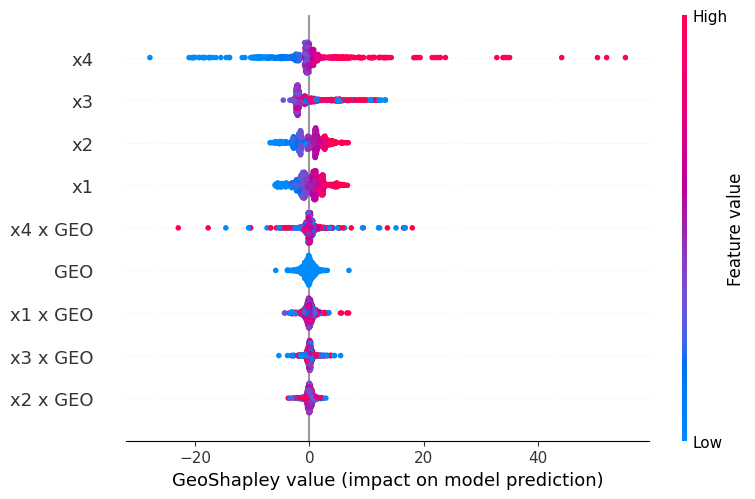

In [ ]:
m_rslt.summary_plot(dpi=100)

In [ ]:
m_rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
x4,-27.905250,-1.594219,-0.306808,0.613696,55.333568,-0.081373,6.562620,3.130505
x3,-4.568143,-2.077319,-1.462881,0.538709,13.325145,-0.027495,3.208611,2.367005
x2,-6.883304,-1.754515,0.163413,1.434624,6.814971,-0.014098,2.280215,1.898263
x1,-5.999700,-1.285689,0.135955,1.391959,6.676384,-0.007497,2.221957,1.753312
x4 x GEO,-22.943766,-0.251772,0.052951,0.404744,18.025969,0.162747,2.397431,0.973402
GEO,-5.878525,-0.612639,-0.100601,0.411754,6.935617,-0.130464,0.917749,0.668865
x1 x GEO,-4.356449,-0.372652,-0.001885,0.398026,6.878950,0.014995,0.976349,0.624267
x3 x GEO,-5.337564,-0.189660,0.043336,0.262385,5.471702,0.054990,0.776865,0.440594
x2 x GEO,-3.689828,-0.231365,0.012653,0.304838,2.890824,0.028197,0.634290,0.418873


### 2-1-3 Extract Raw Shapley

In [ ]:
xvar=['x1','x2','x3','x4']
nvar = len(xvar)
L = list(range(nvar))

In [ ]:
# m_rslt.summary_plot(dpi=150)
m_raw = m_rslt.get_svc(col = L,coef_type='raw',include_primary=True)

# print(m_svc.shape)
final0=np.hstack([m_rslt.base_value + m_rslt.geo.reshape(-1,1), m_raw ])

colname= [f"{col}_shap" for col in xvar]

colname=['beta_shap']+colname
final_df0 = pd.DataFrame(final0, columns=colname)
merged_df = pd.concat([df.reset_index(drop=True), final_df0.reset_index(drop=True)], axis=1)

In [ ]:
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

In [ ]:
columnsvar=['x1_shap','x2_shap', 'x3_shap',  'x4_shap']

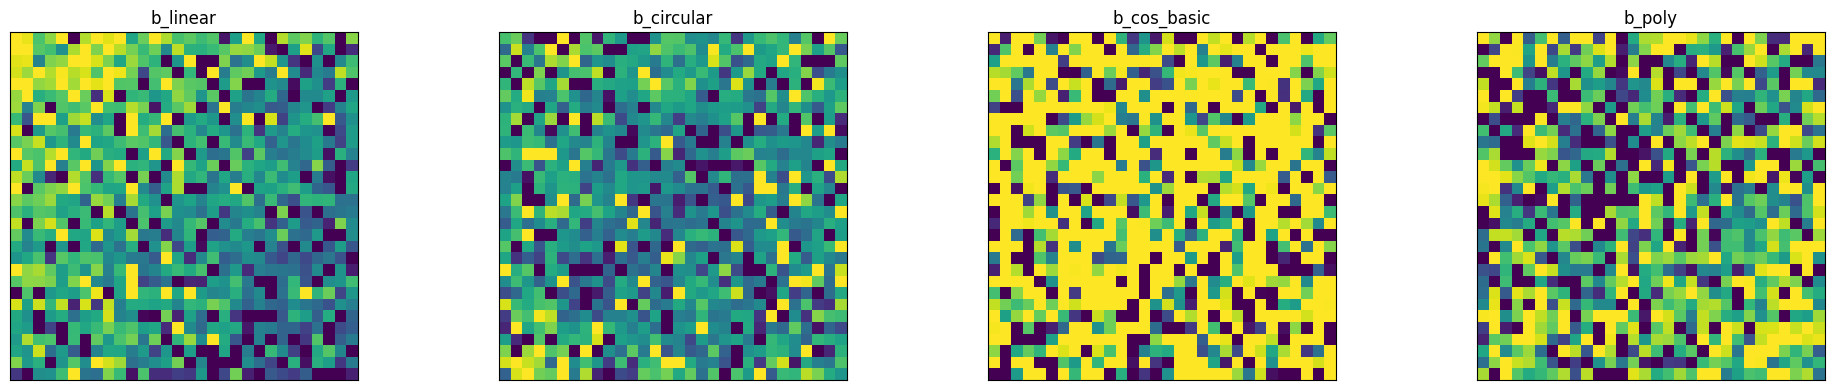

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    # plt.colorbar(im, ax=ax,
    #             #  label='Value',
    #              )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 数据和标题
data_list = [merged_df.pivot(index='u', columns='v', values=i) for i in columnsvar]
titles =targetname

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()

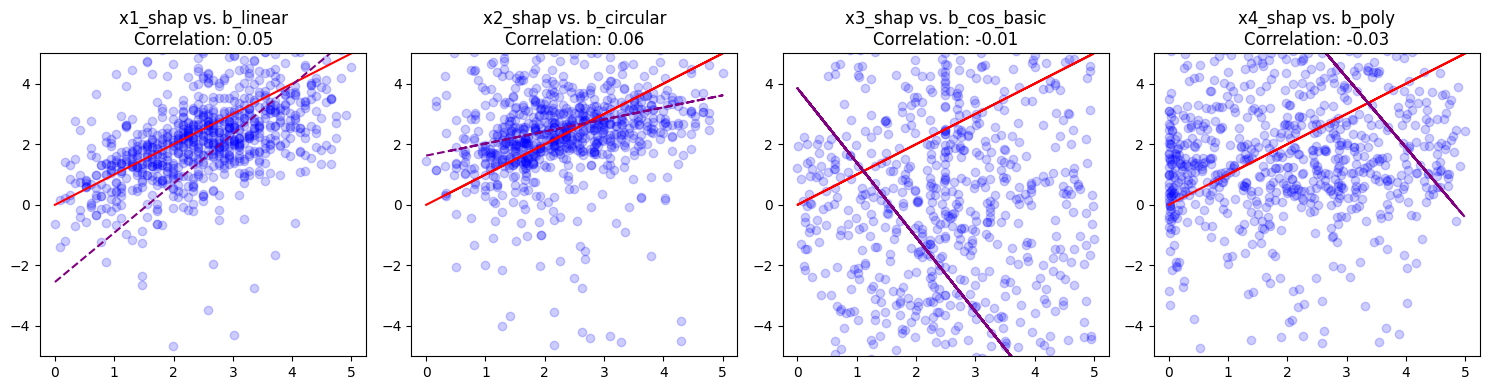

In [ ]:
# 设置图形大小
fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 2行4列

# 假设 feature_importances_df 共有8列，且 targetname 有4个元素
for idx, ax in enumerate(axes.flatten()):
    # 修正：为了在第二行使用不同的列，我们直接使用 idx 来引用列
    feature_column = columnsvar[idx]
    b_column = targetname[idx % 4]  # 使用整除来确保每行对应相同的b_column

    # 获取数据
    y = merged_df[feature_column]
    x = merged_df[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')

    # 绘制拟合直线
    ax.plot(x, x , color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    ax.plot(x, slope * x + intercept, color='purple',ls='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)
    ax.set_ylim(-5, 5)
# 调整布局
plt.tight_layout()
plt.show()

### 2-1-4 Extract GWR smoothed Shapley

In [ ]:
xvar=['x1','x2','x3','x4']
nvar = len(xvar)
L = list(range(nvar))

In [ ]:
# m_rslt.summary_plot(dpi=150)
m_gwr = m_rslt.get_svc(col = L,coef_type='gwr',include_primary=True)

# print(m_svc.shape)
final2=np.hstack([m_rslt.base_value + m_rslt.geo.reshape(-1,1), m_gwr])

colname= [f"{col}_shap" for col in xvar]

colname=['beta_shap']+colname
final_df2= pd.DataFrame(final2, columns=colname)
merged_df12= pd.concat([df.reset_index(drop=True), final_df2.reset_index(drop=True)], axis=1)

In [ ]:
from scipy.stats import linregress

In [ ]:
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

In [ ]:
columnsvar=['x1_shap','x2_shap', 'x3_shap',  'x4_shap']

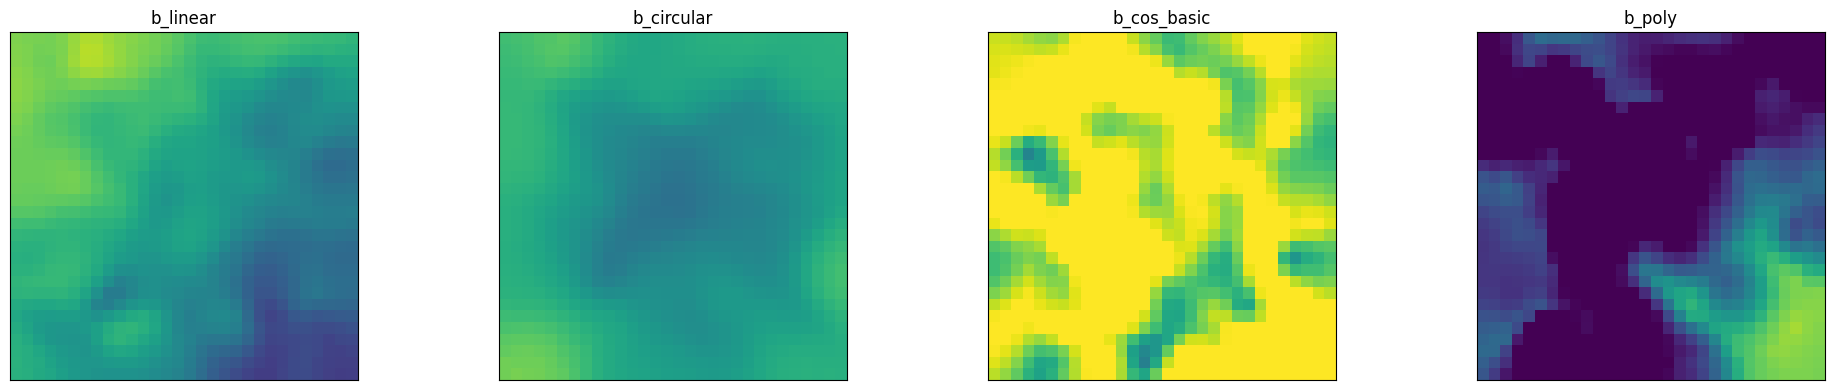

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    # plt.colorbar(im, ax=ax,
    #             #  label='Value',
    #              )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 数据和标题
data_list = [merged_df12.pivot(index='u', columns='v', values=i) for i in columnsvar]
titles =targetname

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()

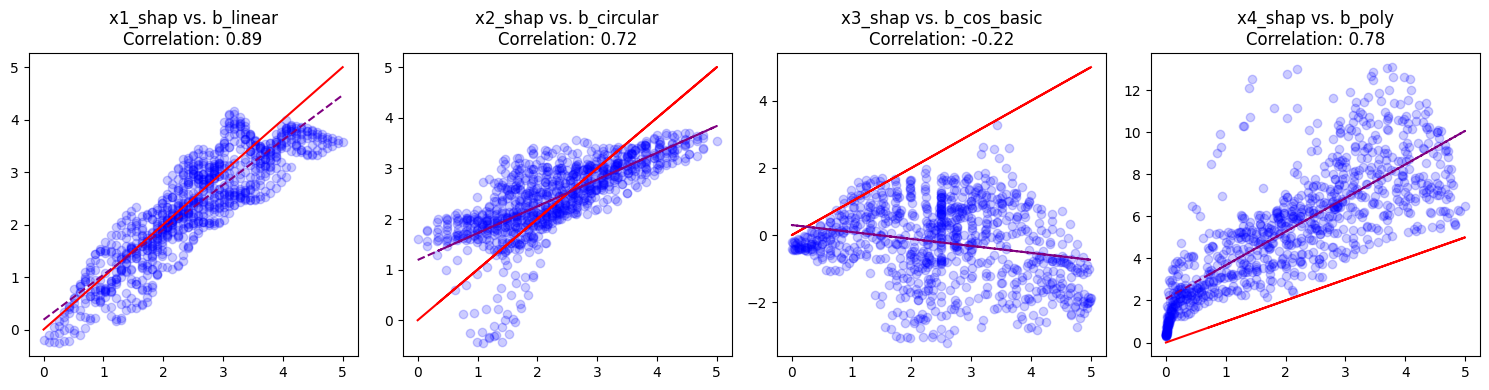

In [ ]:
# 设置图形大小
fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 2行4列

# 假设 feature_importances_df 共有8列，且 targetname 有4个元素
for idx, ax in enumerate(axes.flatten()):
    # 修正：为了在第二行使用不同的列，我们直接使用 idx 来引用列
    feature_column = columnsvar[idx]
    b_column = targetname[idx % 4]  # 使用整除来确保每行对应相同的b_column

    # 获取数据
    y = merged_df12[feature_column]
    x = merged_df12[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')

    # 绘制拟合直线
    ax.plot(x, x , color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    ax.plot(x, slope * x + intercept, color='purple',ls='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)
    # ax.set_ylim(0, 10)
# 调整布局
plt.tight_layout()
plt.show()

### 2-1-5 Partial Dependence Plot

In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.0 MB/s eta 0:00:00


100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


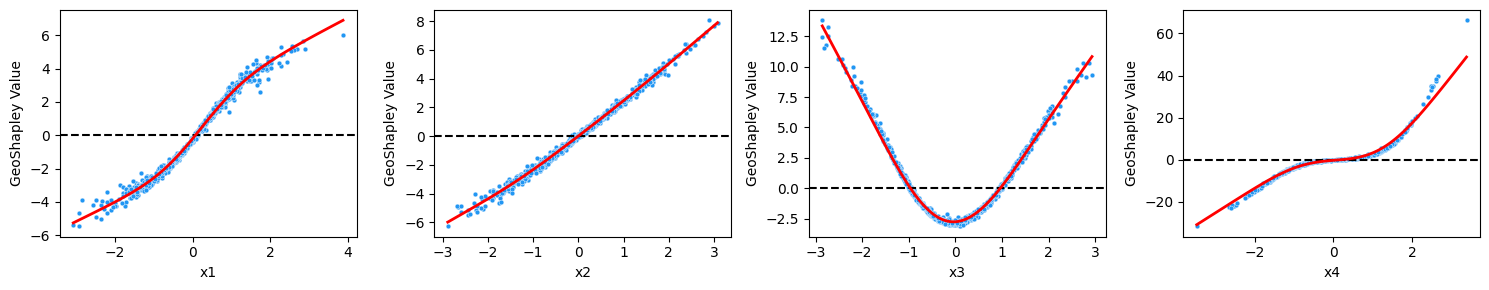

In [ ]:
m_rslt.partial_dependence_plots(figsize=(15,3),max_cols=4,gam_curve=True)

## 2-2 GeoShapley with Hyperopt Models

### 2-2-1 Hpsklearn Models

In [ ]:
import hpsklearn.components
dir(hpsklearn.components)


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_base',
 'ada_boost_classifier',
 'ada_boost_regressor',
 'all_classifiers',
 'all_preprocessing',
 'all_regressors',
 'any_classifier',
 'any_preprocessing',
 'any_regressor',
 'any_sparse_classifier',
 'any_sparse_preprocessing',
 'any_sparse_regressor',
 'any_text_preprocessing',
 'ard_regression',
 'bagging_classifier',
 'bagging_regressor',
 'bayesian_gaussian_mixture',
 'bayesian_ridge',
 'bernoulli_nb',
 'binarizer',
 'categorical_nb',
 'cca',
 'cluster',
 'colkmeans',
 'complement_nb',
 'compose',
 'covariance',
 'cross_decomposition',
 'decision_tree_classifier',
 'decision_tree_regressor',
 'decomposition',
 'discriminant_analysis',
 'dummy',
 'dummy_classifier',
 'dummy_regressor',
 'elastic_net',
 'elastic_net_cv',
 'elliptic_envelope',
 'ensemble',
 'extra_tree_classifier',
 'extra_tree_regressor',
 'extra_trees_classifier',
 'extra_trees_regress

### 2-2-2 Run All Models

In [ ]:
from hpsklearn import extra_trees_regressor,random_forest_regressor,xgboost_regression,gradient_boosting_regressor


In [ ]:
def train_any_model(any_regressor,max_evals=10):
    estim = HyperoptEstimator(regressor=any_regressor("myModel"),preprocessing=[],
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=60,seed=1)
    estim.fit(X_train, y_train)
    return estim


100%|██████████| 1/1 [00:00<00:00,  3.94trial/s, best loss: 0.9976493476636129]

100%|██████████| 2/2 [00:00<00:00,  2.03trial/s, best loss: 0.9306013523725802]

100%|██████████| 3/3 [00:00<00:00,  6.47trial/s, best loss: 0.5072882857875189]

100%|██████████| 4/4 [00:02<00:00,  2.93s/trial, best loss: 0.338240871771752]

100%|██████████| 5/5 [00:00<00:00,  1.71trial/s, best loss: 0.3296200531517217]

100%|██████████| 6/6 [00:01<00:00,  1.35s/trial, best loss: 0.3296200531517217]

100%|██████████| 7/7 [00:00<00:00,  4.27trial/s, best loss: 0.3296200531517217]

100%|██████████| 8/8 [00:00<00:00,  1.02trial/s, best loss: 0.3296200531517217]

100%|██████████| 9/9 [00:00<00:00,  1.97trial/s, best loss: 0.3296200531517217]

100%|██████████| 10/10 [00:00<00:00,  2.90trial/s, best loss: 0.3296200531517217]


  0%|          | 0/900 [00:00<?, ?it/s]

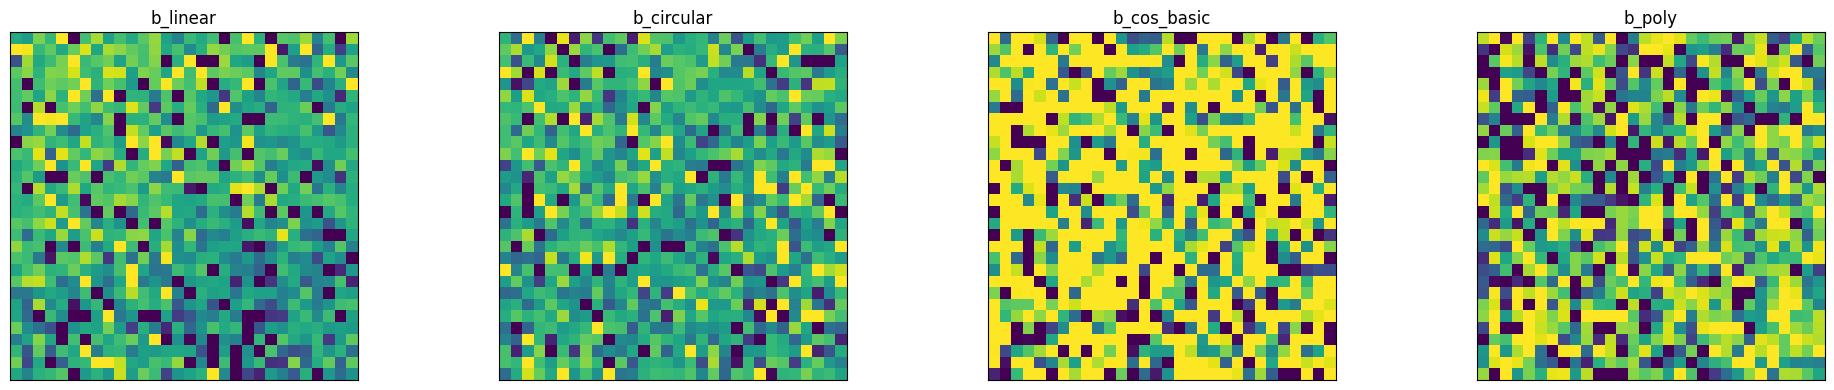

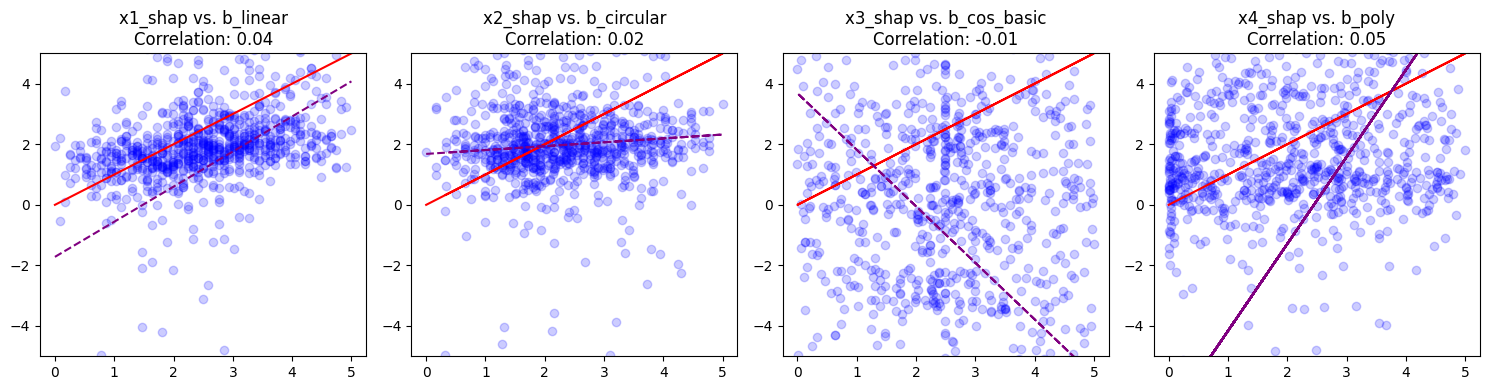

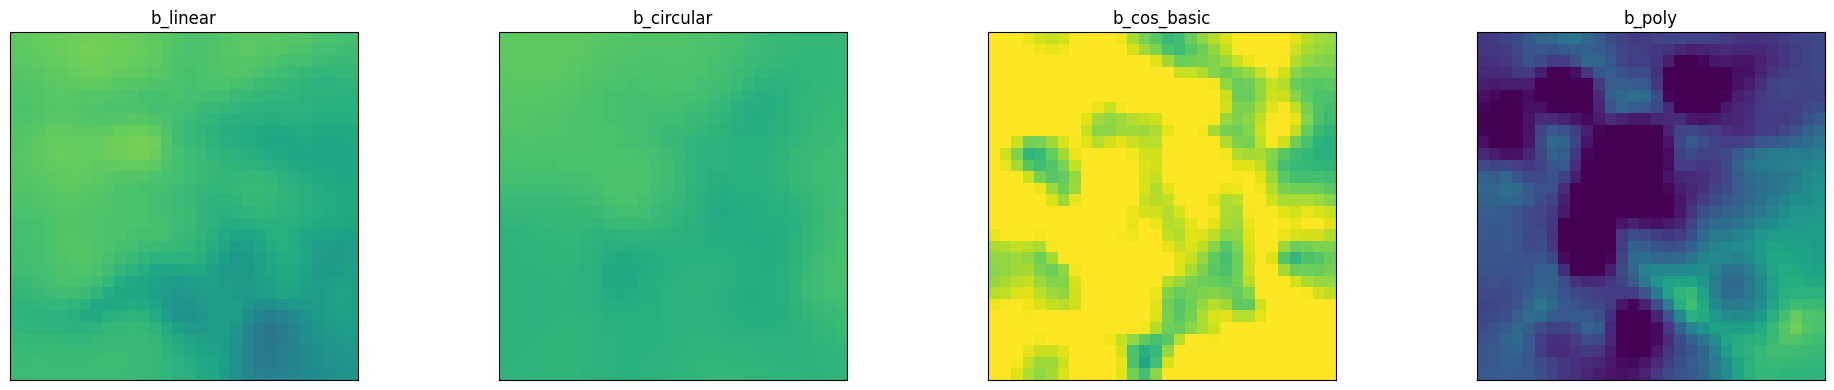

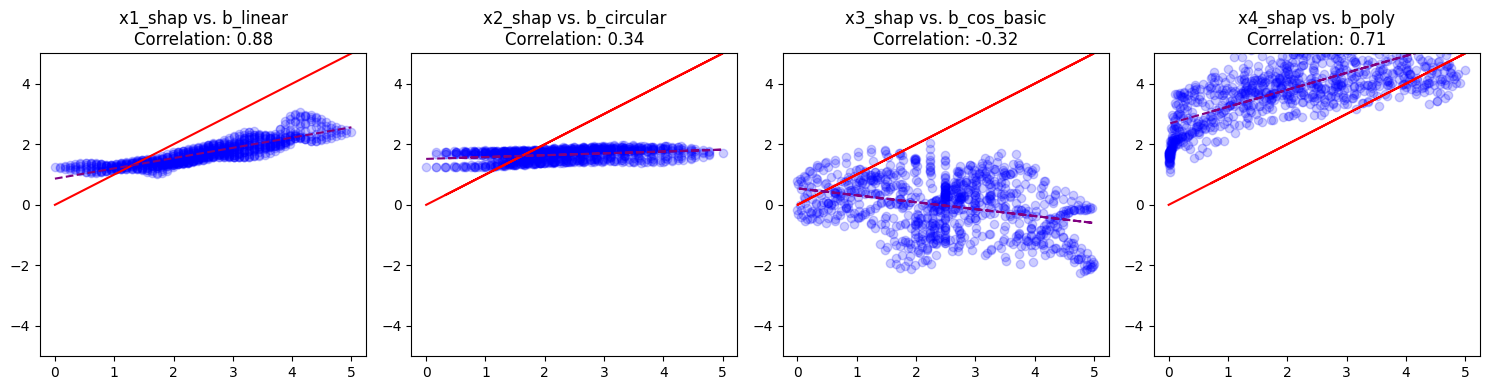


100%|██████████| 1/1 [00:00<00:00,  9.36trial/s, best loss: 0.9337722760090971]

100%|██████████| 2/2 [00:00<00:00,  7.57trial/s, best loss: 0.9337722760090971]

100%|██████████| 3/3 [00:00<00:00,  6.21trial/s, best loss: 0.8945452627555464]

100%|██████████| 4/4 [00:00<00:00,  4.88trial/s, best loss: 0.8867603124745722]

100%|██████████| 5/5 [00:01<00:00,  1.10s/trial, best loss: 0.45661068545220984]

100%|██████████| 6/6 [00:00<00:00,  1.32trial/s, best loss: 0.45661068545220984]

100%|██████████| 7/7 [00:00<00:00, 10.66trial/s, best loss: 0.45661068545220984]

100%|██████████| 8/8 [00:00<00:00,  8.27trial/s, best loss: 0.45661068545220984]

100%|██████████| 9/9 [00:00<00:00,  2.16trial/s, best loss: 0.45661068545220984]

100%|██████████| 10/10 [00:00<00:00,  3.33trial/s, best loss: 0.45661068545220984]


  0%|          | 0/900 [00:00<?, ?it/s]

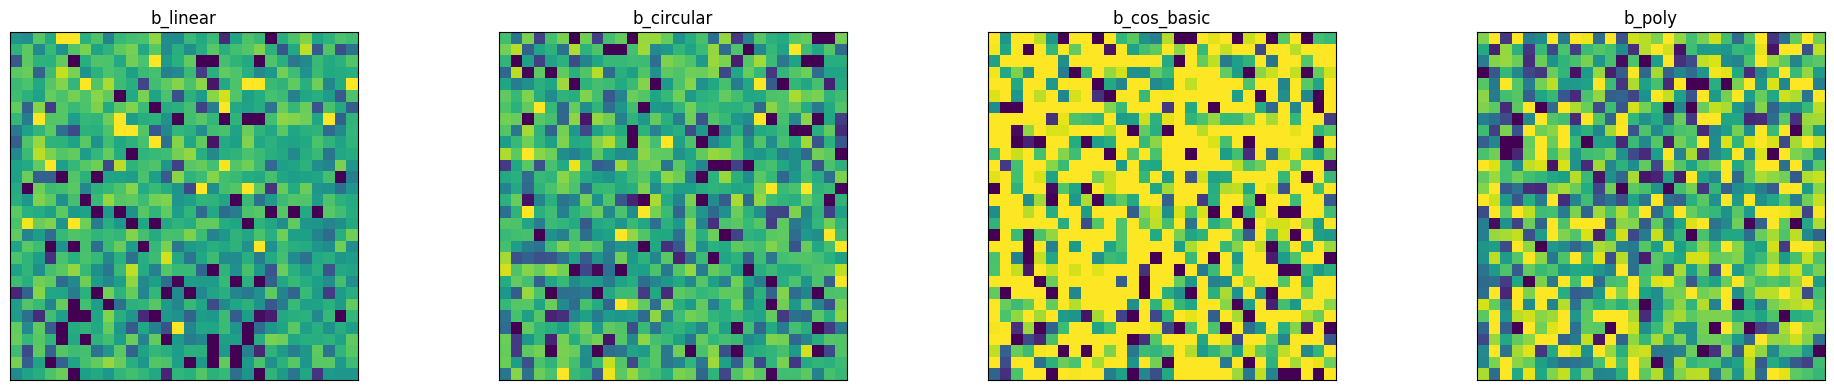

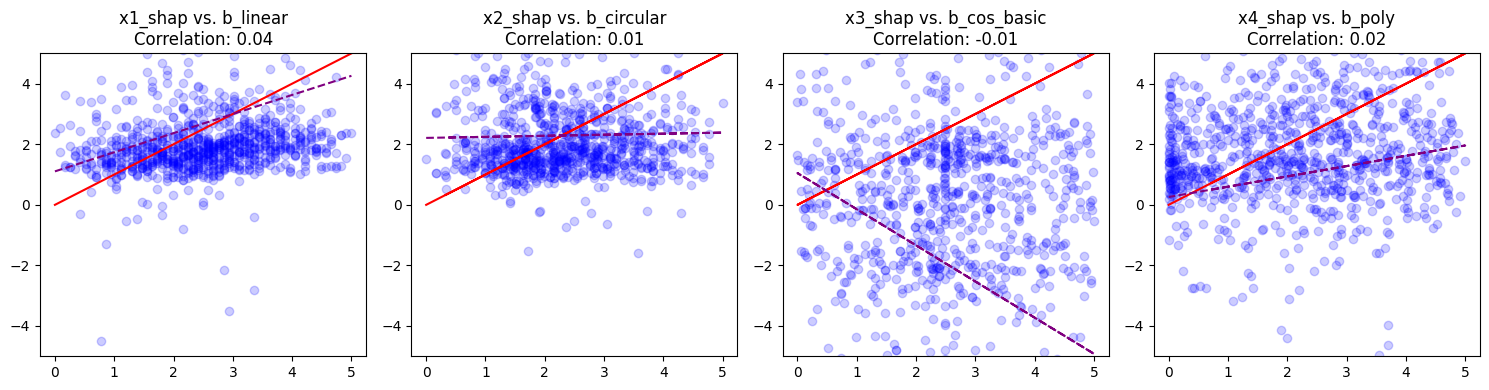

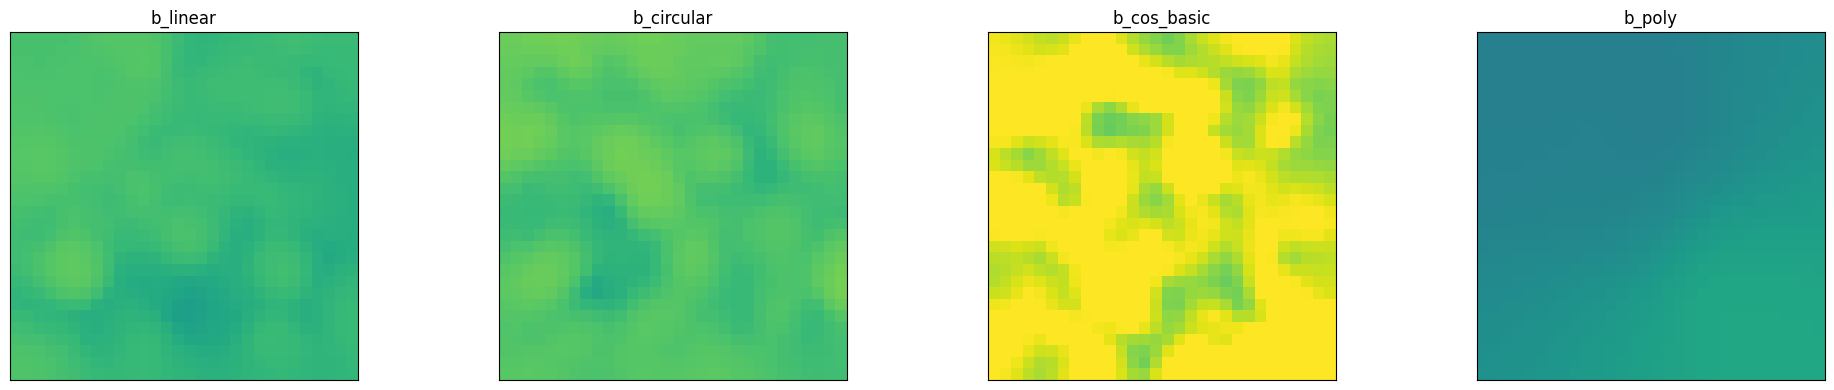

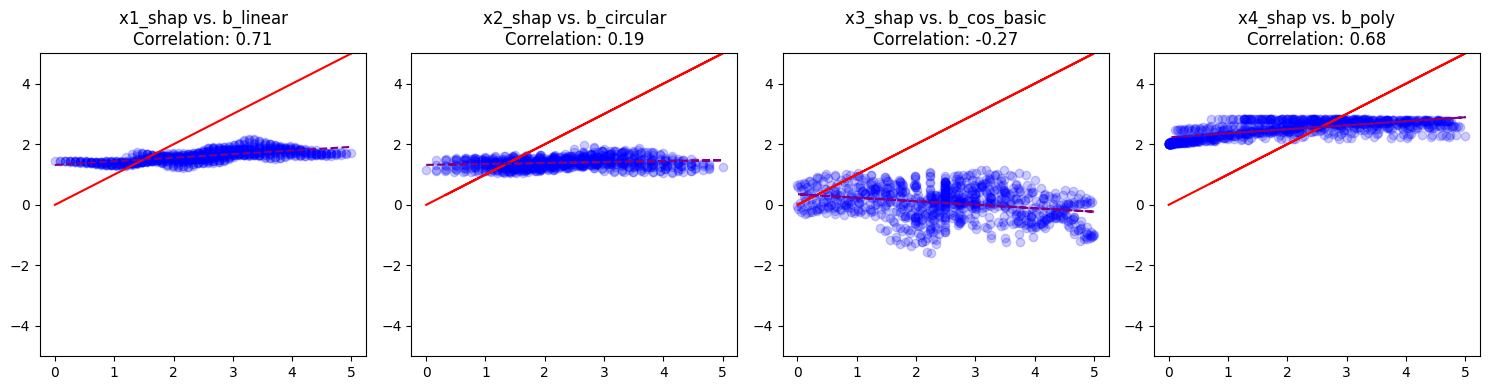


100%|██████████| 1/1 [00:00<00:00,  6.07trial/s, best loss: 0.8760556563840112]

100%|██████████| 2/2 [00:00<00:00,  4.31trial/s, best loss: 0.7157789623877372]

100%|██████████| 3/3 [00:01<00:00,  1.03s/trial, best loss: 0.5065536463677404]

100%|██████████| 4/4 [00:00<00:00,  2.87trial/s, best loss: 0.5065536463677404]

100%|██████████| 5/5 [00:01<00:00,  1.81s/trial, best loss: 0.2962281147753202]

100%|██████████| 6/6 [00:00<00:00,  1.22trial/s, best loss: 0.2962281147753202]

100%|██████████| 7/7 [00:03<00:00,  3.40s/trial, best loss: 0.2596019171711962]

100%|██████████| 8/8 [00:00<00:00,  8.10trial/s, best loss: 0.2596019171711962]

100%|██████████| 9/9 [00:00<00:00,  7.56trial/s, best loss: 0.2596019171711962]

100%|██████████| 10/10 [00:01<00:00,  1.25s/trial, best loss: 0.2596019171711962]


  0%|          | 0/900 [00:00<?, ?it/s]

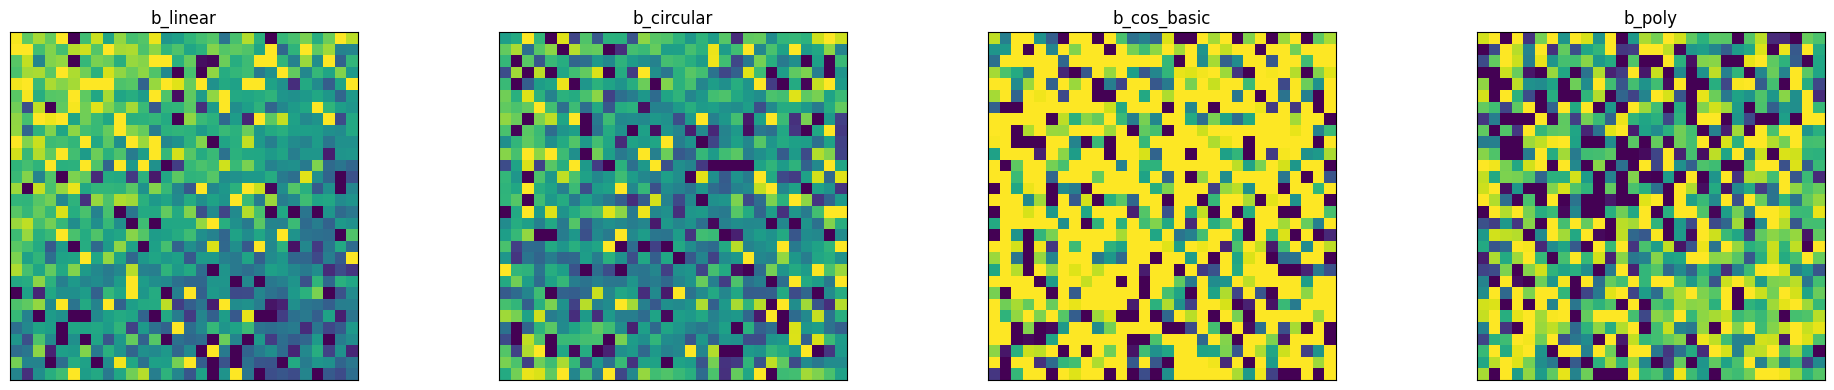

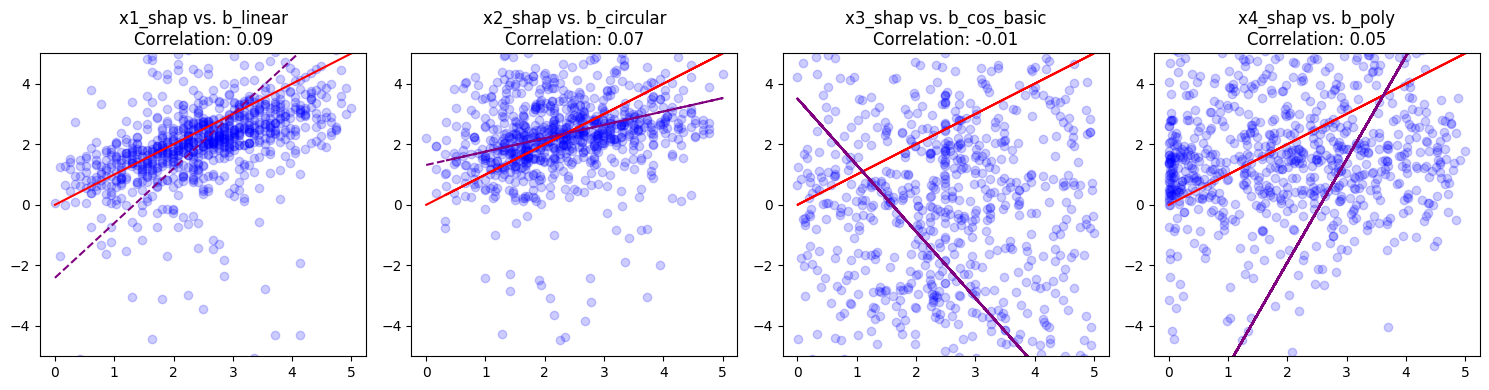

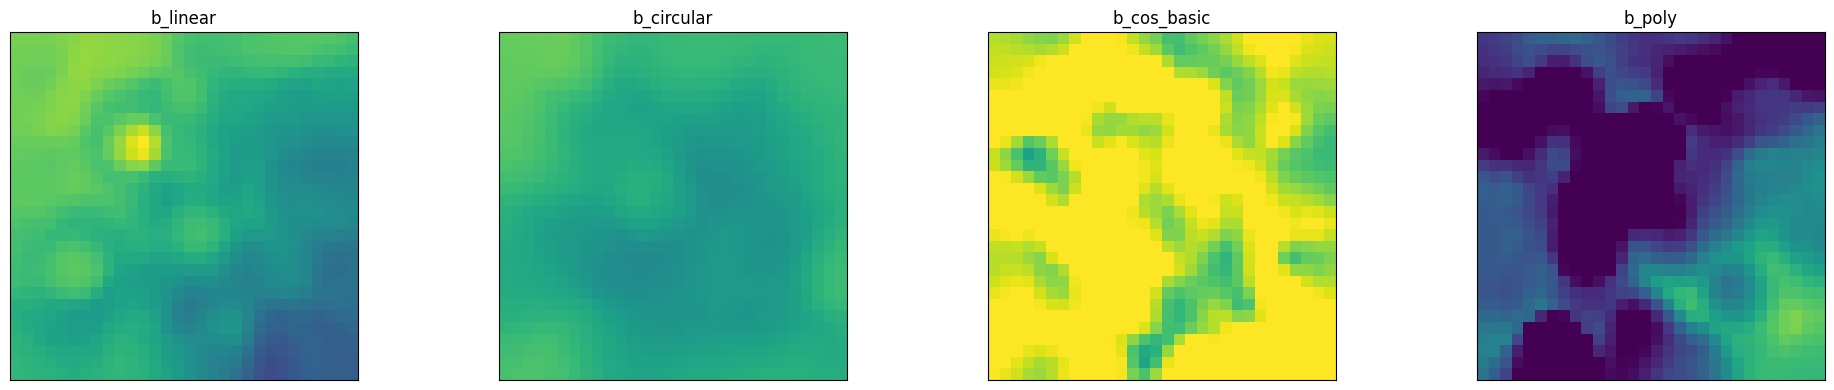

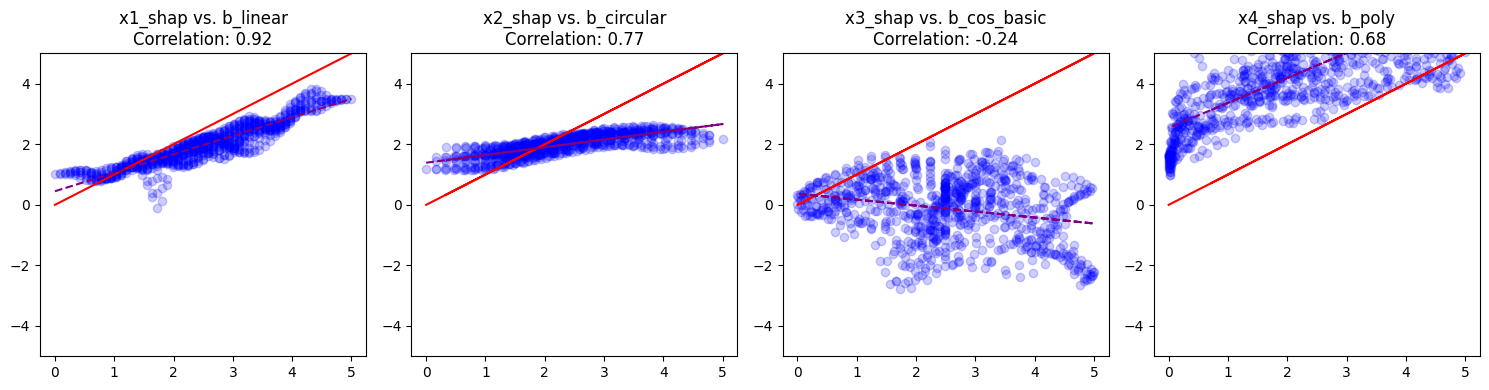


100%|██████████| 1/1 [00:00<00:00,  6.17trial/s, best loss: 1.0001172954770716]

100%|██████████| 2/2 [00:00<00:00,  2.26trial/s, best loss: 0.7155787447108989]

100%|██████████| 3/3 [00:02<00:00,  2.17s/trial, best loss: 0.6686632245177865]

100%|██████████| 4/4 [00:02<00:00,  2.84s/trial, best loss: 0.28186200035018727]

100%|██████████| 5/5 [00:00<00:00,  1.13trial/s, best loss: 0.28186200035018727]

100%|██████████| 6/6 [00:00<00:00,  6.54trial/s, best loss: 0.28186200035018727]

100%|██████████| 7/7 [00:00<00:00,  1.28trial/s, best loss: 0.28186200035018727]

100%|██████████| 8/8 [00:00<00:00,  6.11trial/s, best loss: 0.28186200035018727]

100%|██████████| 9/9 [00:03<00:00,  3.14s/trial, best loss: 0.28186200035018727]

100%|██████████| 10/10 [00:01<00:00,  1.57s/trial, best loss: 0.28186200035018727]


  0%|          | 0/900 [00:00<?, ?it/s]

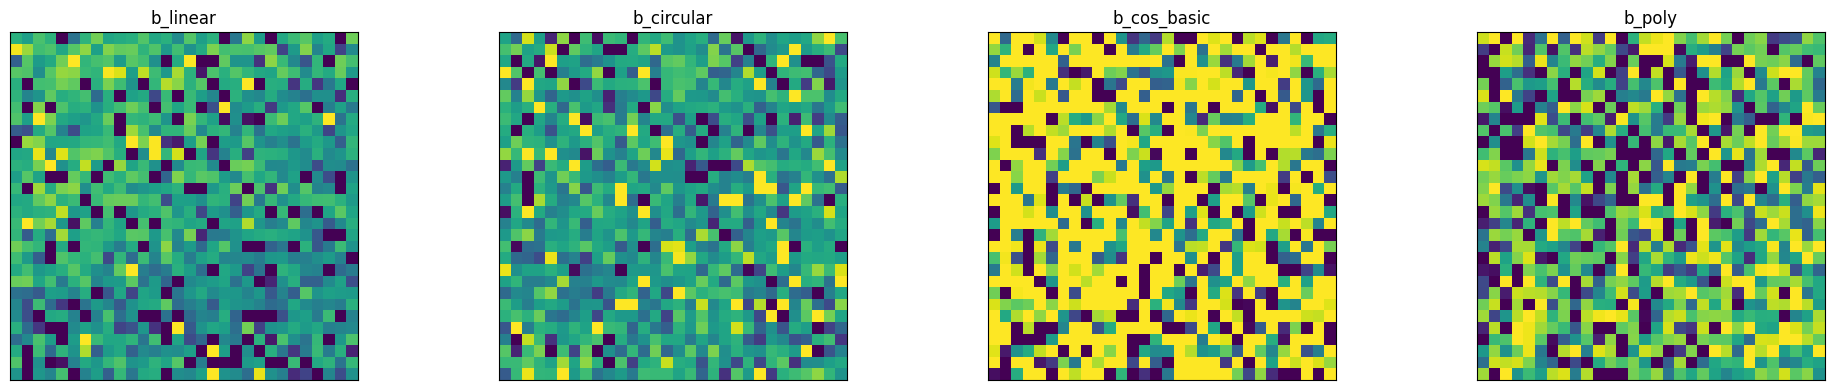

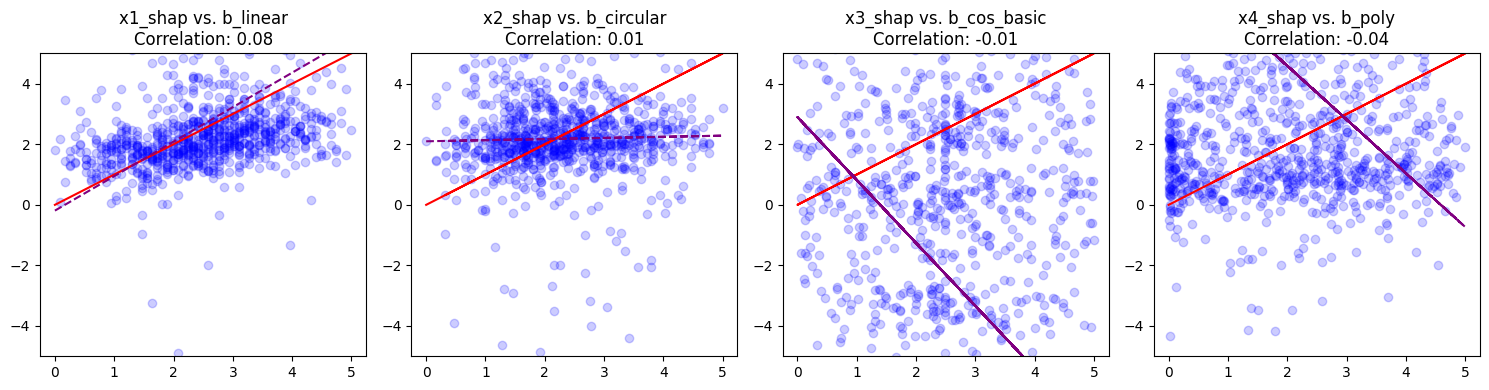

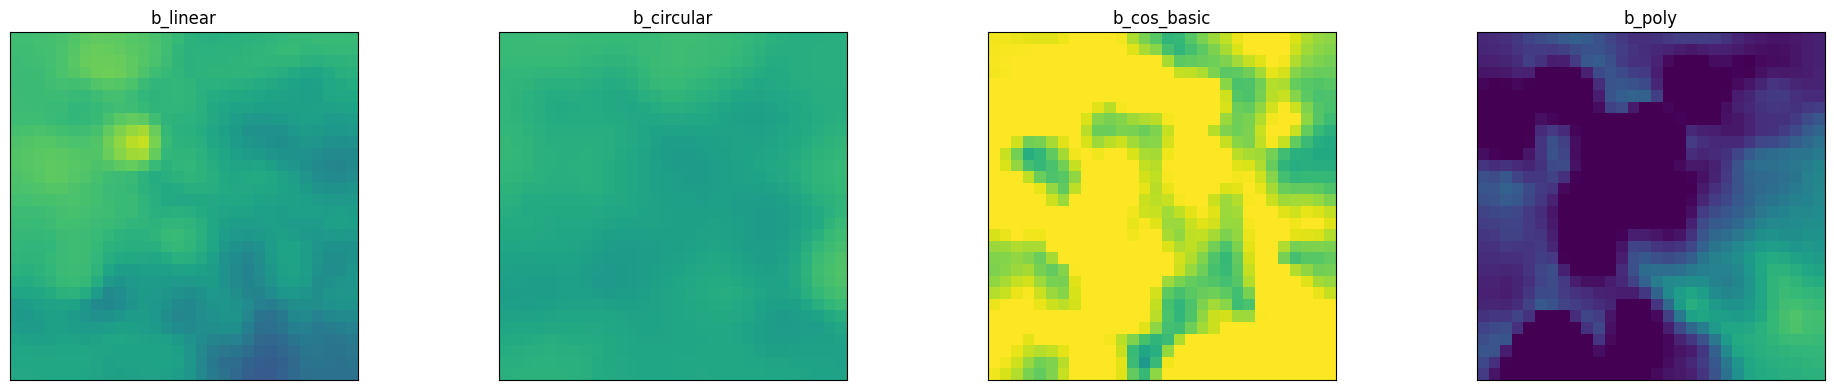

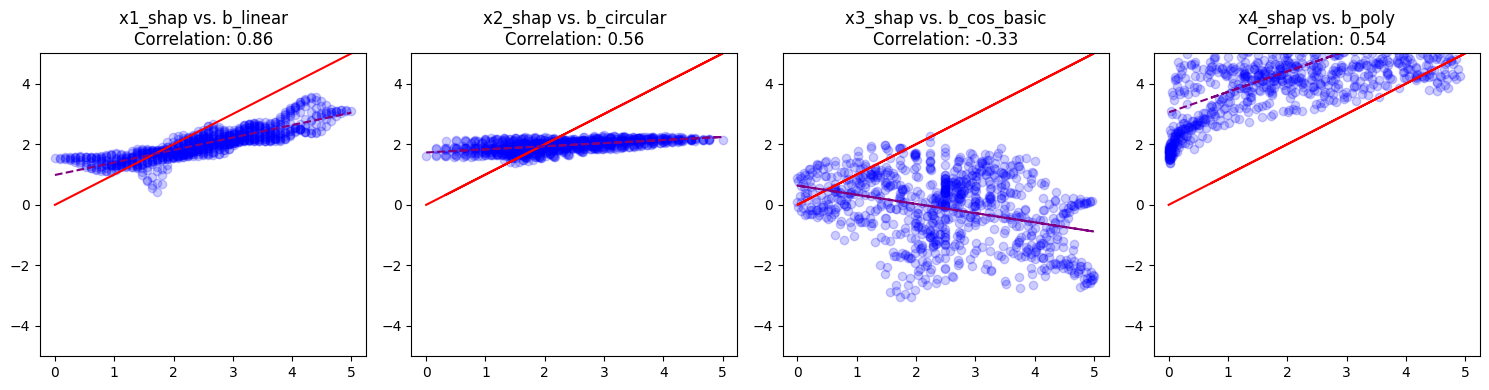

In [ ]:
xvar=['x1','x2','x3','x4']
nvar = len(xvar)
L = list(range(nvar))
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']
columnsvar=['x1_shap','x2_shap', 'x3_shap',  'x4_shap']

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def plotall(merged_df):
  fig, axes = plt.subplots(1, 4, figsize=(20, 4))
  data_list = [merged_df.pivot(index='u', columns='v', values=i) for i in columnsvar]
  titles =targetname
  axes_flat = axes.flatten()
  for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
          plot_heatmap(ax, data, title)
  plt.tight_layout()
  plt.show()

def plotcor(merged_df):
  fig, axes = plt.subplots(1, 4, figsize=(15, 4))
  for idx, ax in enumerate(axes.flatten()):
      feature_column = columnsvar[idx]
      b_column = targetname[idx % 4]
      y = merged_df[feature_column]
      x = merged_df[b_column]
      correlation = np.corrcoef(x, y)[0, 1]
      slope, intercept, r_value, p_value, std_err = linregress(x, y)
      ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')
      ax.plot(x, x , color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
      ax.plot(x, slope * x + intercept, color='purple',ls='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
      ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
      ax.set_ylim(-5, 5)
  # 调整布局
  plt.tight_layout()
  plt.show()

for tm in [extra_trees_regressor,random_forest_regressor,xgboost_regression,gradient_boosting_regressor]:
  for i in range(0,200):
      try:
          m_model = train_any_model(gradient_boosting_regressor)
          break
      except:
          pass
  ypred_train=m_model.predict(X_train)
  ypred_test=m_model.predict(X_test)
  ypred_all=m_model.predict(X_coords)
  r2_score(y_test, ypred_test)
  r2_score(y_train, ypred_train)
  r2_score(y, ypred_all)

  background_X = X_coords.values
  m_explainer = GeoShapleyExplainer(m_model.predict, background_X)
  m_rslt = m_explainer.explain(X_coords,n_jobs=-1)
  m_raw = m_rslt.get_svc(col = L,coef_type='raw',include_primary=True)
  final=np.hstack([m_rslt.base_value + m_rslt.geo.reshape(-1,1), m_raw ])
  colname= [f"{col}_shap" for col in xvar]
  colname=['beta_shap']+colname
  final_df = pd.DataFrame(final, columns=colname)
  merged_df = pd.concat([df.reset_index(drop=True), final_df.reset_index(drop=True)], axis=1)

  plotall(merged_df)
  plotcor(merged_df)


  m_gwr = m_rslt.get_svc(col = L,coef_type='gwr',include_primary=True)
  final2=np.hstack([m_rslt.base_value + m_rslt.geo.reshape(-1,1), m_gwr])
  colname= [f"{col}_shap" for col in xvar]
  colname=['beta_shap']+colname
  final_df2= pd.DataFrame(final2, columns=colname)
  merged_df12= pd.concat([df.reset_index(drop=True), final_df2.reset_index(drop=True)], axis=1)
  plotall(merged_df12)
  plotcor(merged_df12)



